<a href="https://colab.research.google.com/github/lithops-zty/SSEF-RO021/blob/main/multivariate_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import Series

import datetime
from datetime import datetime
from datetime import timedelta
import pytz

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2

from os.path import join

from functools import reduce


import numpy as np
from numpy import array
import pandas as pd
from pandas import Series
import datetime
from datetime import datetime
from datetime import timedelta
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler

from os.path import join
from os import listdir

In [ ]:
year = 2019

In [ ]:
data_root = f"/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_{year}/"
ridership_folder = data_root + "ridership/"
weatherpath = data_root + f"{year}-weather.csv"
holidaypath = data_root + f"{year}-holidays.csv"
stncoorspath = data_root + "stn_info.csv"
covidpath = data_root + f'{year}-covid.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datapaths = [ridership_folder + path for path in listdir(ridership_folder)]

In [ ]:
def get_all_data(): 
  dfs = pd.DataFrame()
  for path in datapaths:
    print(path)
    with open(path, 'r', encoding='utf8', errors='ignore') as f:
      df = pd.read_csv(f, parse_dates=['Start Time', 'End Time'], infer_datetime_format=True)  # interpret the 2 rows as datetime
      df['Start Time'] = pd.to_datetime(df['Start Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce', infer_datetime_format=True)
      df['End Time'] = pd.to_datetime(df['End Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce', infer_datetime_format=True)
    dfs = dfs.append(df)
  return dfs



In [ ]:
df_raw = get_all_data()

/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_2019/ridership/2019-Q2.csv
/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_2019/ridership/2019-Q4.csv
/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_2019/ridership/2019-Q1.csv
/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_2019/ridership/2019-Q3.csv


In [ ]:
df_raw = df_raw.dropna()

In [ ]:
df_raw

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,4802542,183.0,7147,2019-04-01 00:04:00,King St W / Fraser Ave,7233.0,2019-04-01 00:07:00,King / Cowan Ave - SMART,1477,Annual Member
1,4802543,656.0,7013,2019-04-01 00:07:00,Scott St / The Esplanade,7236.0,2019-04-01 00:18:00,Thompson St / Broadview Ave - SMART,3712,Annual Member
2,4802544,302.0,7195,2019-04-01 00:08:00,Ulster St / Bathurst St,7206.0,2019-04-01 00:13:00,Claremont St / Dundas St W,1356,Casual Member
3,4802545,24.0,7233,2019-04-01 00:08:00,King / Cowan Ave - SMART,7233.0,2019-04-01 00:08:00,King / Cowan Ave - SMART,1477,Annual Member
4,4802546,16.0,7233,2019-04-01 00:09:00,King / Cowan Ave - SMART,7233.0,2019-04-01 00:09:00,King / Cowan Ave - SMART,1477,Annual Member
...,...,...,...,...,...,...,...,...,...,...
1130348,6794853,330.0,7281,2019-09-30 23:58:00,Charles St W / Balmuto St - SMART,7006.0,2019-10-01 00:04:00,Bay St / College St (East Side),3331,Annual Member
1130349,6794854,323.0,7281,2019-09-30 23:58:00,Charles St W / Balmuto St - SMART,7006.0,2019-10-01 00:04:00,Bay St / College St (East Side),3355,Annual Member
1130350,6794855,360.0,7011,2019-09-30 23:59:00,Wellington St W / Portland St,7411.0,2019-10-01 00:05:00,Little Norway Park,4091,Annual Member
1130351,6794856,2231.0,7049,2019-09-30 23:59:00,Queen St W / Portland St,7157.0,2019-10-01 00:36:00,Dufferin St / Bloor St,743,Casual Member


#Data preparation

In [ ]:
hour_bins = 3

In [ ]:
hour_resample = str(hour_bins) + "H"

def data_prep(df):
  bor = df[["Start Time", "Start Station Id"]]
  bor = bor.rename(columns={"Start Time": "Time", "Start Station Id": "Station Id"})
  
  ret = df[["End Time", "End Station Id"]]
  ret = ret.rename(columns={"End Time": "Time", "End Station Id": "Station Id"})


  def fill_missing_dates(df):
    idx = pd.date_range(f'{year}/1/1', f'{year}/12/31 23:59:59', freq=hour_resample)
    return df.reindex(pd.MultiIndex.from_product([df.index.levels[0], idx], names=['Station Id', 'Time']), fill_value=0)
    
  def agg(df, name):
    assert df["Time"].isnull().sum() == 0, "missing dates"
    # df['Time'] = df['Time'].apply(lambda x:x.replace(minute=0, second=0))
    df['Time'] = df['Time'].dt.floor(hour_resample)
    df = df.groupby(["Station Id", "Time"]).size().reset_index(name=name)
    df = df.sort_values(["Station Id", "Time", name], ascending=True)
    df = df.set_index(['Station Id', "Time"])

    return df
  
  return pd.concat([fill_missing_dates(agg(bor, "Borrow")), fill_missing_dates(agg(ret, "Return"))], axis=1)



In [ ]:
df = data_prep(df_raw)
df

Borrow  Return
Station Id Time                               
7000       2019-01-01 00:00:00       0     3.0
           2019-01-01 03:00:00       0     0.0
           2019-01-01 06:00:00       2     0.0
           2019-01-01 09:00:00       3     0.0
           2019-01-01 12:00:00       0     0.0
...                                ...     ...
7511       2019-12-31 09:00:00       0     0.0
           2019-12-31 12:00:00       0     0.0
           2019-12-31 15:00:00       0     0.0
           2019-12-31 18:00:00       0     0.0
           2019-12-31 21:00:00       0     0.0

[1369480 rows x 2 columns]

In [ ]:
df = df.fillna(0) # i dunno why but there still are a lot of NaNs
df

Borrow  Return
Station Id Time                               
7000       2019-01-01 00:00:00       0     3.0
           2019-01-01 03:00:00       0     0.0
           2019-01-01 06:00:00       2     0.0
           2019-01-01 09:00:00       3     0.0
           2019-01-01 12:00:00       0     0.0
...                                ...     ...
7511       2019-12-31 09:00:00       0     0.0
           2019-12-31 12:00:00       0     0.0
           2019-12-31 15:00:00       0     0.0
           2019-12-31 18:00:00       0     0.0
           2019-12-31 21:00:00       0     0.0

[1369480 rows x 2 columns]

In [ ]:
df.to_csv(f'{year}_grouped_{hour_bins}hr.csv')
# !cp 2019_grouped_3hr.csv "/content/drive/MyDrive/CENTAD/CENTAD_multivariate"

# Adding multivariate


In [ ]:
def convert_to_datetime(dataframe):
    dataframe["Start Time"] = pd.to_datetime(dataframe["Start Time"], errors = "coerce")
    assert dataframe["Start Time"].isnull().sum() == 0, "missing dates"
    return dataframe

def resample_sum(dataframe):
    dataframe = dataframe.resample(hour_resample, on='Start Time').sum()
    dataframe = dataframe.reset_index()
    return dataframe

def resample_mean(dataframe):
    dataframe = dataframe.resample(hour_resample).mean()
    dataframe = dataframe.reset_index()
    return dataframe

In [ ]:
with open(weatherpath, 'r', encoding='utf8') as f:
  df_weather = pd.read_csv(f, parse_dates=["date_time"], infer_datetime_format=True)

df_weather = df_weather.rename(columns={'date_time':'Time'})

df_weather = df_weather[["Time", "tempC", "FeelsLikeC"]]
df_weather["Time"] = pd.to_datetime(df_weather["Time"], errors = "coerce")
df_weather = df_weather.set_index("Time")
df_weather = resample_mean(df_weather)
df_weather[["tempC", "FeelsLikeC"]] = df_weather[["tempC", "FeelsLikeC"]].round(2)
df_weather = df_weather.set_index("Time")

df_weather

,tempC,FeelsLikeC
Time,,
2019-01-01 00:00:00,7.00,2.67
2019-01-01 03:00:00,3.00,-3.00
2019-01-01 06:00:00,1.33,-5.00
2019-01-01 09:00:00,-0.33,-6.67
2019-01-01 12:00:00,-1.33,-7.67
...,...,...
2019-12-31 09:00:00,1.33,-4.67
2019-12-31 12:00:00,1.00,-5.33
2019-12-31 15:00:00,0.33,-6.00


In [ ]:
df_weather.tail()

,tempC,FeelsLikeC
Time,,
2019-12-31 09:00:00,1.33,-4.67
2019-12-31 12:00:00,1.00,-5.33
2019-12-31 15:00:00,0.33,-6.00
2019-12-31 18:00:00,0.00,-6.33
2019-12-31 21:00:00,-0.33,-6.00


In [ ]:
with open(holidaypath, 'r', encoding='utf8') as f:
  df_holiday = pd.read_csv(f)
  df_holiday["Date"] = pd.to_datetime(df_holiday["Date"], format="%Y-%m-%d %H:%M:%S", errors = "coerce")
  set_holiday = set(df_holiday["Date"])

def add_holidays(dataframe):
  dataframe['IsHoliday'] = dataframe.index.get_level_values(1).map(lambda x:int(pd.Timestamp(x.date()) in set_holiday))
  return dataframe
 


In [ ]:
def add_hour(dataframe):
  dataframe['Hour'] = dataframe.index.get_level_values(1).map(lambda x:x.hour)
  return dataframe

def add_month(dataframe):
  dataframe['Month'] = dataframe.index.get_level_values(1).map(lambda x:x.month)
  return dataframe


In [ ]:
def add_weekday(dataframe):
  dataframe['IsWeekday'] = dataframe.index.get_level_values(1).map(lambda x:int(x.weekday() < 5))
  return dataframe

In [ ]:
def add_weather(dataframe):
  dataframe = dataframe.join(df_weather)
  return dataframe

In [ ]:
with open(covidpath, 'r') as f:
  df_covid = pd.read_csv(f, index_col=0)
  df_covid.index.name = 'Time'
  df_covid.index = pd.to_datetime(df_covid.index, errors = "coerce")

def add_covid(dataframe):
  time_idx = dataframe.index.levels[1]
  dataframe = dataframe.groupby(level=0).apply(lambda d:pd.merge_asof(d, df_covid, 'Time'))
  dataframe.index = dataframe.index.set_levels(time_idx, level=1)
  dataframe = dataframe.drop(columns=['Time'])
  return dataframe


In [ ]:
with open(stncoorspath, 'r', encoding='utf8') as f:
  df_coors = pd.read_csv(f)
  df_coors['idx'] = df_coors['idx'].astype(int)

dict_coors = df_coors.set_index('idx').to_dict('index')
def add_coors(dataframe):
    dataframe['Latitude'] = dataframe.index.get_level_values(0).map(lambda x:dict_coors.get(x, {}).get('latitude', np.nan))
    dataframe['Longitude'] = dataframe.index.get_level_values(0).map(lambda x:dict_coors.get(x, {}).get('longitude', np.nan))
    return dataframe


In [ ]:
df3 = df.copy()

In [ ]:
df3 = add_holidays(df3)

In [ ]:
df3 = add_hour(df3)

In [ ]:
df3 = add_weekday(df3)

In [ ]:
df3 = add_month(df3)

In [ ]:
df3 = add_weather(df3)

In [ ]:
df3 = add_covid(df3)

In [ ]:
df3 = add_coors(df3)
df3 = df3.dropna()

In [ ]:
df3.index = df3.index.set_names('Time', level=1)

In [ ]:
df3

Borrow  Return  ...   Latitude  Longitude
Station Id Time                                 ...                      
7000       2019-01-01 00:00:00       0     3.0  ...  43.639832 -79.395954
           2019-01-01 03:00:00       0     0.0  ...  43.639832 -79.395954
           2019-01-01 06:00:00       2     0.0  ...  43.639832 -79.395954
           2019-01-01 09:00:00       3     0.0  ...  43.639832 -79.395954
           2019-01-01 12:00:00       0     0.0  ...  43.639832 -79.395954
...                                ...     ...  ...        ...        ...
7510       2019-12-31 09:00:00       0     0.0  ...  43.633464 -79.414306
           2019-12-31 12:00:00       0     2.0  ...  43.633464 -79.414306
           2019-12-31 15:00:00       0     0.0  ...  43.633464 -79.414306
           2019-12-31 18:00:00       0     0.0  ...  43.633464 -79.414306
           2019-12-31 21:00:00       0     0.0  ...  43.633464 -79.414306

[1208880 rows x 12 columns]

In [ ]:
df3.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Borrow,Return,IsHoliday,Hour,IsWeekday,Month,tempC,FeelsLikeC,new_cases,new_deaths,Latitude,Longitude
count,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06,1.20888e+06
mean,1.92042,1.92001,0.0273973,10.5,0.715068,6.52603,9.15204,6.71687,0,0,43.6592,-79.3893
std,4.06214,4.16181,0.163238,6.87387,0.451382,3.44785,10.3475,13.1735,0,0,0.0160582,0.0378993
min,0,0,0,0,0,1,-19.33,-32,0,0,43.6187,-79.4867
25%,0,0,0,5.25,0,4,1,-3.67,0,0,43.6475,-79.4117
50%,0,0,0,10.5,1,7,9.33,7,0,0,43.6576,-79.3891
75%,2,2,0,15.75,1,10,18,18,0,0,43.6684,-79.3723
max,129,159,1,21,1,12,30.33,34,0,0,43.7167,-79.2815


In [ ]:
def scale(s):
  return (s - s.min()) / (s.max() - s.min())

def coor(s):
  if s.name in ['Latitude', 'Longitude']:
    s = (s - 0.5).abs() * 2
  return s
corr = df3.apply(scale).groupby(level=0).sum().corr().dropna(axis=0, how='all').dropna(axis=1, how='all')
corr

,Borrow,Return,Month,tempC,FeelsLikeC,Latitude,Longitude
Borrow,1.000000e+00,9.818110e-01,4.958216e-17,3.772040e-17,4.660416e-16,-4.355196e-01,-4.409662e-02
Return,9.818110e-01,1.000000e+00,-6.794511e-16,-7.620519e-16,-9.389155e-16,-4.709149e-01,-2.888383e-02
Month,4.958216e-17,-6.794511e-16,1.000000e+00,1.000000e+00,1.000000e+00,-9.991143e-16,6.350442e-17
tempC,3.772040e-17,-7.620519e-16,1.000000e+00,1.000000e+00,1.000000e+00,-8.479188e-16,1.455940e-16
FeelsLikeC,4.660416e-16,-9.389155e-16,1.000000e+00,1.000000e+00,1.000000e+00,-9.453830e-16,1.131453e-16
Latitude,-4.355196e-01,-4.709149e-01,-9.991143e-16,-8.479188e-16,-9.453830e-16,1.000000e+00,3.702200e-01
Longitude,-4.409662e-02,-2.888383e-02,6.350442e-17,1.455940e-16,1.131453e-16,3.702200e-01,1.000000e+00


In [ ]:
df3[['Borrow', 'Return', 'Longitude', 'Latitude']].apply(scale).corr()

,Borrow,Return,Longitude,Latitude
Borrow,1.000000,0.753060,-0.016822,-0.166141
Return,0.753060,1.000000,-0.011321,-0.184583
Longitude,-0.016822,-0.011321,1.000000,0.370220
Latitude,-0.166141,-0.184583,0.370220,1.000000


In [ ]:
df3[['Borrow', 'Return', 'Longitude', 'Latitude']].groupby(level=0).sum().apply(scale).apply(coor).corr()

,Borrow,Return,Longitude,Latitude
Borrow,1.000000,0.981811,-0.485938,0.091487
Return,0.981811,1.000000,-0.455755,0.143369
Longitude,-0.485938,-0.455755,1.000000,0.052227
Latitude,0.091487,0.143369,0.052227,1.000000


[Text(0, 0, 'Borrow'),
 Text(0, 0, 'Return'),
 Text(0, 0, 'IsHoliday'),
 Text(0, 0, 'Hour'),
 Text(0, 0, 'IsWeekday'),
 Text(0, 0, 'Month'),
 Text(0, 0, 'tempC'),
 Text(0, 0, 'FeelsLikeC'),
 Text(0, 0, 'Latitude'),
 Text(0, 0, 'Longitude')]

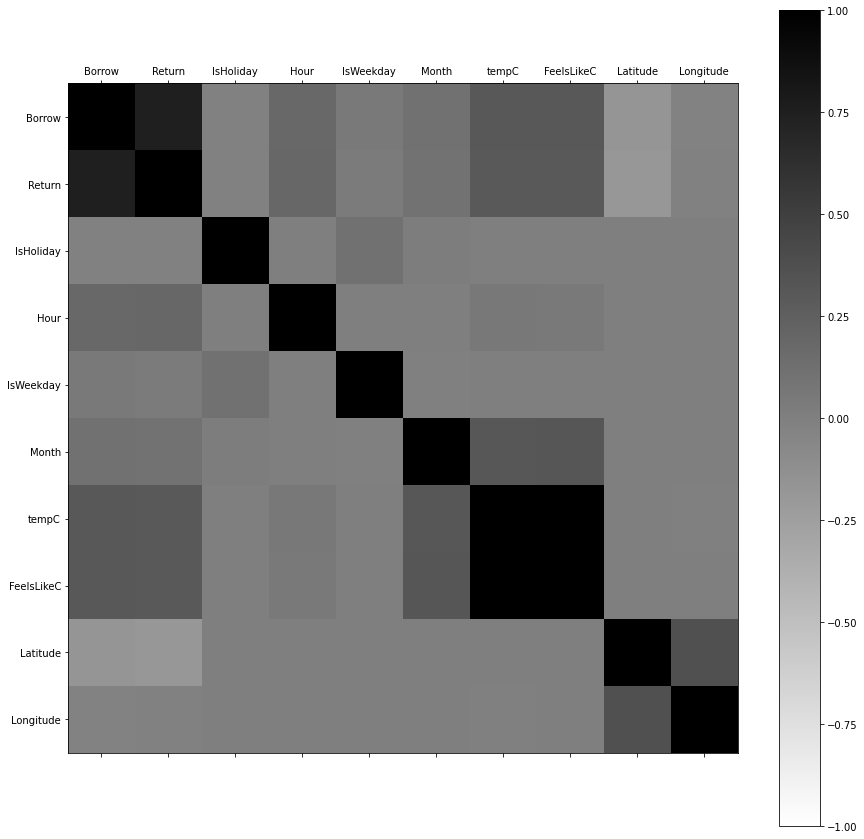

In [ ]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(15,15))

p = ax.matshow(corr, cmap='gray_r', vmin=-1, vmax=1)
plt.colorbar(p)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.index)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.index)

In [ ]:
df3.to_csv(data_root + f'{year}_grouped_{hour_bins}hr_multivariate.csv')
# !cp 2019_grouped_3hr_multivariate.csv "/content/drive/MyDrive/CENTAD/CENTAD_multivariate"

In [ ]:
df_raw[df_raw['Start Time'].apply(lambda x:x.month)]#.describe()

KeyboardInterrupt: ignored

In [ ]:
df3[df3.index.get_level_values(1).month==8].describe()